In [1]:
#execute just the first time to move scripts and dataset from input to output
import sys
from shutil import copytree, copyfile
sys.path.append("/kaggle/input/gta5train/")

src_datasets='/kaggle/input/gta5train/dataset'
dst_datasets='/kaggle/working/datasets/'
copytree(src_datasets, dst_datasets)

sys.path.append("/kaggle/input/cityscapes/")

# src_datasets='/kaggle/input/cityscapes/deeplab_resnet_pretrained_imagenet.pth'
# dst_datasets='/kaggle/working/deeplab_resnet_pretrained_imagenet.pth'
# copyfile(src_datasets, dst_datasets)

src_datasets='/kaggle/input/cityscapes/Cityscapes_v2.py'
dst_datasets='/kaggle/working/datasets/Cityscapes_v2.py'
copyfile(src_datasets, dst_datasets)

src_models='/kaggle/input/cityscapes/models'
dst_models='/kaggle/working/models/'
copytree(src_models, dst_models)

copyfile(src = "/kaggle/input/cityscapes/utils.py", dst = "/kaggle/working/utils.py")
copyfile(src = "/kaggle/input/utilities/GTA5_Dacs_bs2_epoch50_weights.pth", dst = "/kaggle/working/GTA5_Dacs_bs2_epoch50_weights.pth")
copyfile(src = "/kaggle/input/utilities/customPlot.py", dst = "/kaggle/working/customPlot.py")
copyfile(src = "/kaggle/input/utilities/dacs.py", dst = "/kaggle/working/dacs.py")

'/kaggle/working/dacs.py'

In [2]:
#this one you need it always
import sys
sys.path.append("/kaggle/input/gta5train/dataset/")
sys.path.append("/kaggle/input/cityscapes/datasets/")

In [3]:
import torch.nn.functional as F
import torch.nn as nn
from cityscapes import CityScapes
from gta5 import GTA5
from torch.utils.data import DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from models.bisenet.build_bisenet import BiSeNet
from models.bisenet.build_contextpath import build_contextpath
from utils import poly_lr_scheduler
from customPlot import *
from dacs import *

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=19):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
#         return np.nanmean(iou_per_class)
        return np.array(iou_per_class)
       
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image

def print_tensor(t):
    img_t = convert_tensor_to_image(t)
    plt.plot(figsize=(5,5))
    plt.imshow(img_t.cpu().detach().numpy())
    plt.show()

def train(model, optimizer, train_loader, target_loader, loss_fn):
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    accuracy = 0.0
    ii = 0

    target_iter = iter(target_loader)
    max_target_iter=250
    target_counter=0
    for batch_idx, source_batch in enumerate(train_loader):
        if target_counter >= max_target_iter:
            target_iter = iter(target_loader)
            target_counter = 0
        ii += 1

        try:
            target_batch = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            target_batch = next(target_iter)
        target_counter+=1
        inputs, targets = source_batch
        target_inputs, _ = target_batch

        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.float()
        targets = targets.squeeze(dim=1)
        target_inputs = target_inputs.to(device).float()

        # Step 5: Generate pseudo-labels for target domain images
        with torch.no_grad():
            logits_u_w = model(target_inputs)[0]
            pseudo_label = torch.softmax(logits_u_w, dim=1)
            max_probs, targets_u_w = torch.max(pseudo_label, dim=1)

        # Step 6: Create mixed images and pseudo-labels
        batch_size = inputs.size(0)
        MixMask = []
        for image_i in range(batch_size):
            classes = torch.unique(targets[image_i])
            nclasses = classes.shape[0]
            selected_classes = classes[torch.Tensor(np.random.choice(nclasses, int((nclasses + nclasses % 2) / 2), replace=False)).long()].to(device)
            MixMask.append(generate_class_mask(targets[image_i], selected_classes).unsqueeze(0).to(device))

        inputs_u_s_list, targets_u_s_list = [], []
        for i, mask in enumerate(MixMask):
            strong_parameters = {"Mix": mask, "ColorJitter": 0.2, "GaussianBlur": 0.5, "flip": 0.5}
            inputs_u_s, targets_u_s = strongTransform(strong_parameters, data=torch.cat((inputs[i].unsqueeze(0), target_inputs[i].unsqueeze(0))), target=torch.cat((targets[i].unsqueeze(0), targets_u_w[i].unsqueeze(0))))
            inputs_u_s_list.append(inputs_u_s)
            targets_u_s_list.append(targets_u_s)

        inputs_u_s = torch.cat(inputs_u_s_list)
        targets_u_s = torch.cat(targets_u_s_list)

        # Step 7: Compute predictions for mixed images
        logits_u_s = model(inputs_u_s)[0]
        L_u = F.cross_entropy(logits_u_s, targets_u_s, ignore_index=255, reduction='none')
        mask = max_probs.ge(0.968).float()
        L_u = (L_u * mask).mean()

        # Compute predictions for source images
        outputs, _, _ = model(inputs)
        L_s = loss_fn(outputs.to(dtype=torch.float32), targets.squeeze(dim=1).to(dtype=torch.int64))
#         L_s = loss_fn(outputs.to(dtype=torch.float32), targets.to(dtype=torch.int64))

        # Combine supervised and unsupervised losses
        loss = L_s + L_u

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        iou_score += mIoU(outputs.to(device), targets.to(device))
        accuracy += pixel_accuracy(outputs.to(device), targets.to(device))

    train_loss = running_loss / len(train_loader)
    iou_score = iou_score / len(train_loader)
    accuracy = accuracy / len(train_loader)
    return train_loss, iou_score, accuracy

# Test loop
def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    iou_score=0.0
    accuracy=0.0
    
    with torch.no_grad():
        for batch_idx,(inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()
            targets = targets.int()
            
            #Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs.to(dtype=torch.float32), targets.squeeze(dim=1).to(dtype=torch.int64))
            iou_score += mIoU(outputs.to(device), targets.to(device))
            accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
            test_loss += loss.item()
            
    test_loss = test_loss / len(test_loader)
    iou_score = iou_score / len(test_loader)
    accuracy = accuracy / len(test_loader)
    return test_loss,iou_score,accuracy

gta_path = '/kaggle/input/gta5train/'
image_train = gta_path+'GTA5/GTA5/images/'
sem_map_train = gta_path+'labels_correct/labels_correct/'
cityscapes_path = '/kaggle/input/cityscapes/Cityscapes/Cityscapes/Cityspaces/'
image_val = cityscapes_path+'images/val'
sem_map_val = cityscapes_path+'gtFine/val'
image_unlabelled = cityscapes_path+'images/train'
cityscapes_label = cityscapes_path+'gtFine/train'

resize_transform_gta = v2.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (720,1280))
resize_transform = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (512,1024))

num_classes=19

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
# gta_train = GTA5(annotations_dir=sem_map_train, images_dir=image_train,transform=resize_transform_gta) #to train with gta5 
cityscapes_val = CityScapes(annotations_dir=sem_map_val, images_dir=image_val,transform=resize_transform) #to validate with cityscapes

gta_mix = GTA5(annotations_dir=sem_map_train, images_dir=image_train,transform=resize_transform) #gta images to be mixed
cityscapes_mix = CityScapes(annotations_dir=cityscapes_label, images_dir=image_unlabelled,transform=resize_transform) # cityscapes images to be mixed

bs = 50
# train_loader = DataLoader(gta_train, batch_size=bs, shuffle=True)
gta_mix_loader = DataLoader(gta_mix, batch_size=bs, shuffle=True)
mix_loader = DataLoader(cityscapes_mix, batch_size=bs, shuffle=True)

val_loader = DataLoader(cityscapes_val, batch_size=bs, shuffle=True)

In [5]:
model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
epoch = 0 #to initialize the lr
start_lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
l_rate = poly_lr_scheduler(optimizer, init_lr=start_lr , iter=epoch, lr_decay_iter=1, max_iter=50, power=0.9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 159MB/s]  


In [6]:
for param in model.context_path.parameters():
    param.requires_grad=False 

In [ ]:
from torchinfo import summary
summary(model, input_size=(bs,3,512,1024), col_names=["num_params", "trainable"])

In [ ]:
train_iou_list=[]
train_acc_list=[]
train_loss_list=[]
test_iou_list=[]
class_iou_list=[]
test_acc_list=[]
test_loss_list=[]

In [ ]:
''' 
    Dacs Schedule:
        use model from previous iter to generate pseudo-labels for cityscapes (target)
        mix cityscapes and gta image
        mix cityscapes and gta pseudo-label and label
        train model with gta images (source)
        train model with mixed images and labels
        evaluate the model on cityscape validation split
'''

In [ ]:
# Train the model

epoch_beginning = 0
epochs = 50

for epoch in range(epoch_beginning,epochs):
    n_epoch = epoch+1
    l_rate = poly_lr_scheduler(optimizer, init_lr=start_lr , iter=epoch, lr_decay_iter=1, max_iter=50, power=0.9)
    #train
    train_loss,train_iou,train_acc = train(model, optimizer, gta_mix_loader, mix_loader, loss_fn)
    train_iou = np.nanmean(train_iou)
    train_iou_list.append(train_iou)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
    #save model
    if n_epoch%5 == 0 or n_epoch==epochs:
        model_name = f"bisenet_GTA5_bs{bs}_epoch{n_epoch}_weights.pth"
        torch.save(model.state_dict(), model_name)
        
    #test    
    test_loss,class_iou,test_acc = test(model, val_loader, loss_fn)
    test_iou = np.nanmean(class_iou)
    test_iou_list.append(test_iou)
    class_iou_list.append(class_iou)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print(f"Epoch: {n_epoch}")
    print(f"- Train Acc: {train_acc:.3f}")
    print(f"- Train Loss: {train_loss:.3f}")
    print(f"- Train mIoU: {train_iou:.3f}\n")
    print(f"- Test Acc: {test_acc:.3f}")
    print(f"- Test Loss: {test_loss:.3f}")
    print(f"- Test mIoU: {test_iou:.3f}")
    if n_epoch == 1 or n_epoch == epochs:
        print(f"- Iou per Class: {class_iou}")
    print("__________________________")

In [ ]:
# Plot Graphs
metrics = np.stack(arrays=[train_iou_list ,train_acc_list , train_loss_list, test_iou_list, test_acc_list, test_loss_list], axis=0)

names = ["mIou", "Accuracy", "Loss"]
plotted = 0
plt.figure(figsize=(15,3))
for i in range(len(names)):
    plotted += 1
    plt.subplot(1,3,plotted) 
    plt.plot(range(1, 51), metrics[i], label="Train")
    plt.plot(range(1, 51), metrics[i+len(names)], label="Test")
    plt.title(f"{names[i]}")
    plt.legend()
plt.show()

# Plot Mixed Images

In [7]:
path_weights="/kaggle/input/utilities/GTA5_Dacs_bs2_epoch50_weights.pth"
model.load_state_dict(torch.load(path_weights, map_location=device))

<All keys matched successfully>

In [8]:
model.train()
running_loss = 0.0
iou_score = 0.0
accuracy = 0.0
ii = 0
train_loader = gta_mix_loader
target_loader = mix_loader

target_iter = iter(target_loader)
max_target_iter=250
target_counter=0

if target_counter >= max_target_iter:
    target_iter = iter(target_loader)
    target_counter = 0
ii += 1

try:
    target_batch = next(target_iter)
except StopIteration:
    target_iter = iter(target_loader)
    target_batch = next(target_iter)
target_counter+=1

inputs, targets = next(iter(train_loader)) #gta images to mix
target_inputs, _ = target_batch #cityscapes images to mix
inputs, targets = inputs.to(device), targets.to(device)
inputs = inputs.float()
targets = targets.squeeze(dim=1)
target_inputs = target_inputs.to(device).float()

# Step 5: Generate pseudo-labels for target domain images
with torch.no_grad():
    logits_u_w = model(target_inputs)[0]
    pseudo_label = torch.softmax(logits_u_w, dim=1)
    max_probs, targets_u_w = torch.max(pseudo_label, dim=1)

# Step 6: Create mixed images and pseudo-labels
batch_size = inputs.size(0)
MixMask = []
for image_i in range(batch_size):
    classes = torch.unique(targets[image_i])
    nclasses = classes.shape[0]
    selected_classes = classes[torch.Tensor(np.random.choice(nclasses, int((nclasses + nclasses % 2) / 2), replace=False)).long()].to(device)
    MixMask.append(generate_class_mask(targets[image_i], selected_classes).unsqueeze(0).to(device))
    
inputs_u_s_list, targets_u_s_list = [], []
for i, mask in enumerate(MixMask):
    strong_parameters = {"Mix": mask, "ColorJitter": 0.2, "GaussianBlur": 0.5, "flip": 0.5}
    inputs_u_s, targets_u_s = strongTransform(strong_parameters, data=torch.cat((inputs[i].unsqueeze(0), target_inputs[i].unsqueeze(0))), target=torch.cat((targets[i].unsqueeze(0), targets_u_w[i].unsqueeze(0))))
    inputs_u_s_list.append(inputs_u_s)
    targets_u_s_list.append(targets_u_s)
    
inputs_u_s = torch.cat(inputs_u_s_list)
targets_u_s = torch.cat(targets_u_s_list)

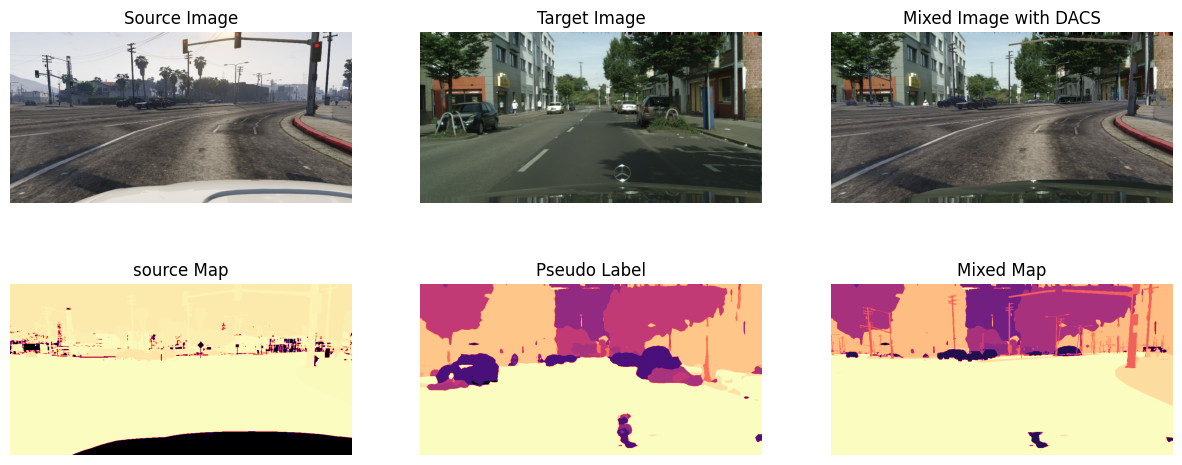

In [9]:
plot_dacs(s_img=inputs, t_img=target_inputs, mix_img=inputs_u_s, s_map=targets, ps_lbl=targets_u_w, mix_lbl=targets_u_s, i=0, c_map="magma_r")

# Plot Predicted Map

In [10]:
plot_loader = DataLoader(cityscapes_val, batch_size=1, shuffle=True)
path_weights="/kaggle/input/utilities/GTA5_Dacs_bs2_epoch50_weights.pth"
model.load_state_dict(torch.load(path_weights, map_location=device))

<All keys matched successfully>

mIoU: 0.410
Accuracy: 0.797


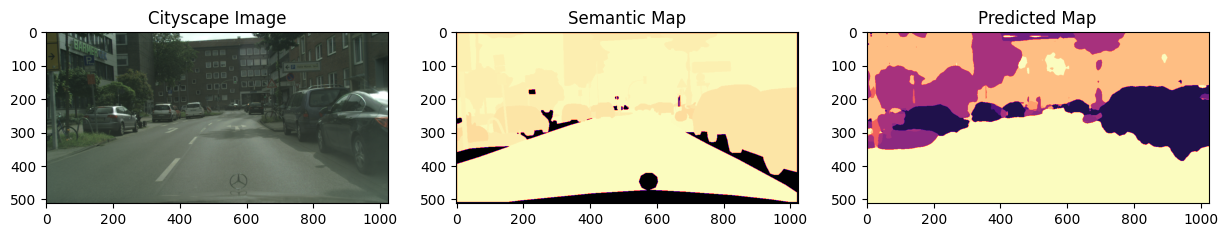

In [11]:
model.eval()
img, sem_map = next(iter(plot_loader))
img, sem_map = img.to(device), sem_map.to(device)
img = img.float()
sem_map = sem_map.int()
outputs = model(img)
softmax = nn.Softmax(dim=1)
prediction = torch.argmax(softmax(outputs),axis=1)

iou_ex = mIoU(outputs.to(device), sem_map.to(device))
acc_ex = pixel_accuracy(outputs.to(device), sem_map.to(device))
print(f'mIoU: {np.nanmean(iou_ex):.3f}')
print(f"Accuracy: {acc_ex:.3f}")

plot_prediction(img, sem_map, prediction, c_map="magma_r")